Let's demonstrate how to simulate a "micrograph" in cryojax.

This is a bit more of an advanced tutorial because it will demonstrate how to combine `equinox` and `jax.vmap` to compute a superposition of images of the same particle at random poses. The main functions of interest from `equinox` are `equinox.partition` and `equinox.combine`. Read about them more [here](https://docs.kidger.site/equinox/api/manipulation/#equinox.partition).

We will also demonstrate how to use `jaxlie`, which is the `cryojax` engine for computing and parameterizing rotations.

This is not necessarily a good model of a micrograph, so this is why we put micrograph in quotations. Mostly, this is a tutorial for `equinox` and `jaxlie`!

In [1]:
# Jax imports
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
from jax import config
from jaxlie import SO3
from functools import partial

config.update("jax_enable_x64", False)

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# CryoJAX imports
import cryojax.simulator as cs
from cryojax.io import read_volume_with_voxel_size_from_mrc

In [4]:
# Configure the image parameters
image_dim = 600
shape = (image_dim, image_dim)
pixel_size = 4.4  # Angstroms
image_size = image_dim * pixel_size

First, we will sample different poses of our particle. To do this, we will use the [`jaxlie.SO3.sample_uniform`](https://brentyi.github.io/jaxlie/api/jaxlie/#jaxlie.SO3.sample_uniform) method. The `jaxlie.SO3` object is heavily used in `cryojax`. In fact, accessing an `AbstractPose.rotation` property will return a `jaxlie.SO3` object.

The most important detail when creating a group of `jaxlie.SO3` objects below is the `jax.vmap` transformation to `jaxlie.SO3.sample_uniform`. Think of it like this: `SO3.sample_uniform` is typed to construct a single `SO3` instance. If we want to construct many `SO3` instances, we can wrap this constructor in a `vmap` transformation.

To learn about this more, read the section of the equinox documentation on [model ensembling](https://docs.kidger.site/equinox/tricks/#ensembling).

In [5]:
# Sample a group of uniform rotations and translations
keys = jax.random.split(jax.random.PRNGKey(0), 100)
# ... rotations
rotations = jax.vmap(lambda key: SO3.sample_uniform(key))(keys)
# ... translations
offsets_in_angstroms = jax.vmap(
    lambda key: jax.random.uniform(
        key, (3,), minval=-image_size / 2.1, maxval=image_size / 2.1
    )
)(keys)
offsets_in_angstroms /= jnp.asarray([1.0, 1.0, image_size / 2])

Now, build the `cryojax` image formation model components.

In [6]:
# Now, instantiate the poses
poses = jax.vmap(lambda R, t: cs.QuaternionPose.from_rotation_and_translation(R, t))(
    rotations, offsets_in_angstroms
)

# ... load the scattering potential and projection method
filename = "../../tests/data/3j9g_potential_ps4_4.mrc"
real_voxel_grid, voxel_size = read_volume_with_voxel_size_from_mrc(filename)
config = cs.ImageConfig(shape, pixel_size, pad_scale=2.0)
potential = cs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2.0
)
integrator = cs.FourierSliceExtract(config)

# ... build the specimen
specimen = cs.Specimen(potential, poses)

# ... and finally the instrument
optics = cs.WeakPhaseOptics(ctf=cs.CTF(defocus_u_in_angstroms=10000.0, defocus_v_in_angstroms=10000.0))
instrument = cs.Instrument(optics)

Finally, use equinox in order to compute the image superposition. Read more about this by learning about [pytree manipulation](https://docs.kidger.site/equinox/api/manipulation/) routines in equinox. In particular, read about [eqx.partition and eqx.combine](https://docs.kidger.site/equinox/api/manipulation/#equinox.partition).

This thread on the `equinox` github may also be useful: [https://github.com/patrick-kidger/equinox/issues/618](https://github.com/patrick-kidger/equinox/issues/618).

In [7]:
@partial(jax.vmap, in_axes=[0, None])
def compute_image_stack(vmap, novmap):
    """Compute image stack."""
    pipeline = eqx.combine(vmap, novmap)
    return pipeline.render()


@jax.jit
def compute_stack_and_sum(vmap, novmap):
    """Compute the stack and sum."""
    return jnp.mean(compute_image_stack(vmap, novmap), axis=0)


@jax.jit
def compute_micrograph(specimen, integrator, instrument):
    """Build the model and compute the superposition."""
    pipeline = cs.ImagePipeline(specimen, integrator, instrument)
    is_vmap = lambda x: isinstance(x, cs.AbstractPose)
    to_vmap = jax.tree_util.tree_map(is_vmap, pipeline, is_leaf=is_vmap)
    vmap, novmap = eqx.partition(pipeline, to_vmap)
    return compute_stack_and_sum(vmap, novmap)

(<Figure size 550x550 with 2 Axes>,
 <Axes: title={'center': 'Sum of random poses'}>)

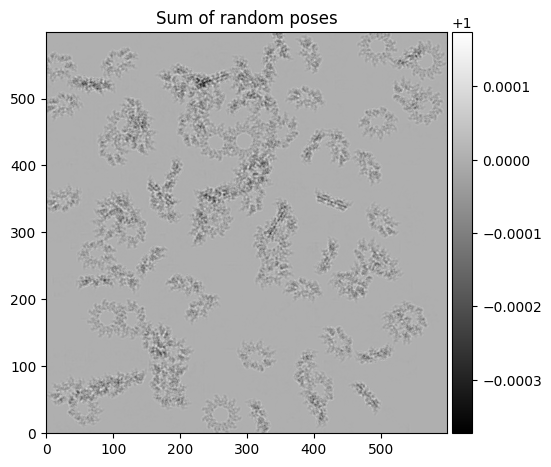

In [8]:
# Compute the image and plot
fig, ax = plt.subplots(figsize=(5.5, 5.5))
micrograph = compute_micrograph(specimen, integrator, instrument)
plot_image(micrograph, fig, ax, label="Sum of random poses", interpolation=None)